In [1]:
#!pip install geoplot
#!pip install contextily
#!pip install altair

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import geopandas as gpd 
import nltk
nltk.download('punkt')
#import contextily as ctx
#import geoplot as gplt
#import geoplot.crs as gcrs
#import folium
#import seaborn as sns
#import altair as alt 

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Part I : Obtention du dataframe 
## 1.1.Récupération des loyers, des surfaces et de la localisation des résidences

In [3]:

df = pd.read_csv("https://data.enseignementsup-recherche.gouv.fr//explore/dataset/fr_crous_logement_france_entiere/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false", 
                 sep =';')


In [4]:
df = df[["title", "infos", "address" ,"geocalisation", "regions"]]

In [5]:
from functions_for_data_cleaning_file_modelling import *

df = get_loyer(df)
df = get_surface(df)
df = get_localisation(df) 
df

[nltk_data] Downloading package punkt to /home/onyxia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],9.0,9.0,9.0,4.014345,49.241905,POINT (4.01435 49.24191)
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],18.0,18.0,18.0,4.713102,49.772858,POINT (4.71310 49.77286)
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],18.0,18.0,18.0,4.007765,49.236553,POINT (4.00777 49.23655)
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",21.0,21.0,21.0,7.051274,43.625690,POINT (7.05127 43.62569)
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",20.0,16.0,18.0,6.016348,43.134247,POINT (6.01635 43.13425)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],9.0,9.0,9.0,1.061514,49.467331,POINT (1.06151 49.46733)
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],18.0,18.0,18.0,1.078162,49.433716,POINT (1.07816 49.43372)
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.0,1.067396,49.460327,POINT (1.06740 49.46033)
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.6,-0.365822,49.194141,POINT (-0.36582 49.19414)


## 1.2.Récupération des loyers privés des communes (avec la géolocalisation des communes)

In [6]:
df_private = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/8fac6fb7-cd07-4747-8e0b-b101c476f0da", encoding= 'unicode_escape', sep = ";")


On ne garde que le code INSEE, le nom de la ville et le loyer supérieur par m^2


In [7]:
df_private = df_private[["INSEE", "LIBGEO","upr.IPm2"]]

On renomme la colonne INSEE en codgeo pour pouvoir la merger avec la carte des contours des villes.

In [8]:
df_private.rename(columns = {'INSEE':'codgeo'}, inplace = True)

In [9]:
"""
On rajoute un 0 devant le code INSEE quand il ne fait que quatre chiffres (pour uniformiser avec l'autre base).
"""
for i in range(0,df_private.shape[0]):
    if  len(df_private["codgeo"][i]) == 4: 
            df_private["codgeo"][i] = "0" +  df_private["codgeo"][i]

In [10]:
df_private = df_private.set_index('codgeo') #on réindex le dataframe avec le code INSEE pour merger après. 

On récuppère les contours géographique des communes.(prends du temps)

In [11]:
gdf_communes_boundaries = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/e9391593-fa95-4153-aabe-87ca84d197e9")

ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


On ne garde que le code INSEE et les données polygoniales. 

In [12]:
gdf_communes_boundaries.rename(columns = {'INSEE_COM':'codgeo'}, inplace = True)
gdf_communes_boundaries = gdf_communes_boundaries[["codgeo", "geometry"]]
gdf_communes_boundaries = gdf_communes_boundaries.set_index('codgeo')


On concatène les deux datafarmes

In [13]:
gdf_private = pd.concat([df_private,gdf_communes_boundaries], axis = 1, join = "inner")

## 1.3. Jointures spatiales

In [14]:

#gdf_private['geometry'] = gdf_private['geometry'].apply(wkt.loads) #on transforme en format wkt (sinon ça ne marche pas)
gdf_private = gpd.GeoDataFrame(gdf_private)  #on transforme en geodataframe 
df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within 
#i.e si le point est dans le polynôme. 

/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_3173/2580680376.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_private, how='left', op='within') #on réalise la jointure à gauche avec within


In [15]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],9.0,9.0,9.0,4.014345,49.241905,POINT (4.01435 49.24191),Reims,"14,57326171"
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],18.0,18.0,18.0,4.713102,49.772858,POINT (4.71310 49.77286),Charleville-Mézières,"11,56216505"
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],18.0,18.0,18.0,4.007765,49.236553,POINT (4.00777 49.23655),Reims,"14,57326171"
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",21.0,21.0,21.0,7.051274,43.625690,POINT (7.05127 43.62569),Valbonne,"22,22505174"
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",20.0,16.0,18.0,6.016348,43.134247,POINT (6.01635 43.13425),La Garde,"16,7739299"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],9.0,9.0,9.0,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341"
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],18.0,18.0,18.0,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357"
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.0,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341"
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.6,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394"


## 1.4 Ajout des départements 

In [16]:
gdf_dep = gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
gdf_dep.rename(columns = {'nom':'departement'}, inplace = True)
gdf_dep = gdf_dep[["departement", "geometry"]]
gdf_dep

,departement,geometry
0,La Réunion,"MULTIPOLYGON (((55.21643 -21.03904, 55.21652 -..."
1,Aude,"POLYGON ((1.68872 43.27368, 1.69001 43.27423, ..."
2,Haute-Loire,"POLYGON ((3.08206 45.28988, 3.08209 45.29031, ..."
3,Bouches-du-Rhône,"MULTIPOLYGON (((4.23014 43.46047, 4.23025 43.4..."
4,Lot-et-Garonne,"POLYGON ((-0.14058 44.22648, -0.12931 44.23218..."
...,...,...
97,Morbihan,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,Doubs,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,Jura,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,Ardèche,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."


In [17]:
df = gpd.sjoin(df, gdf_dep, how='left', op='within')


/opt/mamba/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3373: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_3173/3352756710.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  df = gpd.sjoin(df, gdf_dep, how='left', op='within')


In [18]:
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,index_right,departement
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],9.0,9.0,9.0,4.014345,49.241905,POINT (4.01435 49.24191),Reims,"14,57326171",44,Marne
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],18.0,18.0,18.0,4.713102,49.772858,POINT (4.71310 49.77286),Charleville-Mézières,"11,56216505",46,Ardennes
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],18.0,18.0,18.0,4.007765,49.236553,POINT (4.00777 49.23655),Reims,"14,57326171",44,Marne
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",21.0,21.0,21.0,7.051274,43.625690,POINT (7.05127 43.62569),Valbonne,"22,22505174",17,Alpes-Maritimes
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",20.0,16.0,18.0,6.016348,43.134247,POINT (6.01635 43.13425),La Garde,"16,7739299",51,Var
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],9.0,9.0,9.0,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",9,Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],18.0,18.0,18.0,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",9,Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.0,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",9,Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.6,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",69,Calvados


In [19]:
del df['index_right'] #on supprime l'index right pour la prochaine jointure
df

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],9.0,9.0,9.0,4.014345,49.241905,POINT (4.01435 49.24191),Reims,"14,57326171",Marne
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],18.0,18.0,18.0,4.713102,49.772858,POINT (4.71310 49.77286),Charleville-Mézières,"11,56216505",Ardennes
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],18.0,18.0,18.0,4.007765,49.236553,POINT (4.00777 49.23655),Reims,"14,57326171",Marne
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",21.0,21.0,21.0,7.051274,43.625690,POINT (7.05127 43.62569),Valbonne,"22,22505174",Alpes-Maritimes
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",20.0,16.0,18.0,6.016348,43.134247,POINT (6.01635 43.13425),La Garde,"16,7739299",Var
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],9.0,9.0,9.0,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],18.0,18.0,18.0,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.0,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.6,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",Calvados


## 1.5. Association de résidences à une école 

In [20]:
df.crs = "epsg:4326" #on définit la projection de notre dataframe

In [21]:
"""
Calcul d'un cercle de 20 km autour de la résidence
"""
df1 = df
df1 = df1.to_crs(epsg = 3395) #On prend une projection en mètres
df1['geometry'] = df1['geometry'].buffer(20000) #On prend un rayon de 20km 
df1 = df1.to_crs(4326) #on repasse dans la projection uselle 
df1

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],9.0,9.0,9.0,4.014345,49.241905,"POLYGON ((4.19401 49.24191, 4.19314 49.23037, ...",Reims,"14,57326171",Marne
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],18.0,18.0,18.0,4.713102,49.772858,"POLYGON ((4.89276 49.77286, 4.89190 49.76145, ...",Charleville-Mézières,"11,56216505",Ardennes
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],18.0,18.0,18.0,4.007765,49.236553,"POLYGON ((4.18743 49.23655, 4.18656 49.22502, ...",Reims,"14,57326171",Marne
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",21.0,21.0,21.0,7.051274,43.625690,"POLYGON ((7.23094 43.62569, 7.23007 43.61290, ...",Valbonne,"22,22505174",Alpes-Maritimes
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",20.0,16.0,18.0,6.016348,43.134247,"POLYGON ((6.19601 43.13425, 6.19515 43.12135, ...",La Garde,"16,7739299",Var
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],9.0,9.0,9.0,1.061514,49.467331,"POLYGON ((1.24118 49.46733, 1.24031 49.45585, ...",Mont-Saint-Aignan,"14,84543341",Seine-Maritime
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],18.0,18.0,18.0,1.078162,49.433716,"POLYGON ((1.25783 49.43372, 1.25696 49.42223, ...",Rouen,"14,85000357",Seine-Maritime
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",17.0,12.0,14.0,1.067396,49.460327,"POLYGON ((1.24706 49.46033, 1.24619 49.44885, ...",Mont-Saint-Aignan,"14,84543341",Seine-Maritime
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",20.0,9.0,14.6,-0.365822,49.194141,"POLYGON ((-0.18616 49.19414, -0.18702 49.18260...",Caen,"14,34459394",Calvados


In [22]:
"""
Import de notre base de données des écoles 
"""
df_schools = pd.read_csv("https://www.data.gouv.fr/fr/datasets/r/0c713161-26fb-415e-ac1d-8769125f338d", sep = ";")

In [23]:
df_schools = df_schools[df_schools["annee_universitaire"] == "2021-22" ] #on ne prend que l'année 2021-22
df_schools = df_schools[["etablissement_lib", "effectif_sans_cpge", "etablissement_code_commune", "etablissement_commune"]]

In [24]:
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_code_commune,etablissement_commune
427,Université de Strasbourg,54534,67482,Strasbourg
428,Université Toulouse Capitole,17867,31555,Toulouse
429,École nationale supérieure des sciences de l'i...,234,69266,Villeurbanne
430,Université Paris 1 - Panthéon Sorbonne,40413,75105,Paris 5e
431,Université Jean Moulin - Lyon 3,25559,69387,Lyon 7e
...,...,...,...,...
2283,École nationale supérieure de l'électronique e...,874,95127,Cergy
2284,Université Paris-Est Créteil,39198,94028,Créteil
2285,Aix-Marseille Université,71711,13207,Marseille 7e
2286,École nationale supérieure des arts et techniq...,216,69385,Lyon 5e


In [25]:
df_schools.rename(columns = {'etablissement_code_commune':'codgeo'}, inplace = True) #On renomme la colonne pour la jointure


In [26]:
index_with_nan = df_schools.index[df_schools.isnull().any(axis=1)]
df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes

/tmp/ipykernel_3173/123655656.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_schools.drop(index_with_nan,0, inplace=True) #on enlève les valeurs manquantes


In [27]:
df_schools.set_index('codgeo', inplace = True)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune
codgeo,,,
67482,Université de Strasbourg,54534,Strasbourg
31555,Université Toulouse Capitole,17867,Toulouse
69266,École nationale supérieure des sciences de l'i...,234,Villeurbanne
75105,Université Paris 1 - Panthéon Sorbonne,40413,Paris 5e
69387,Université Jean Moulin - Lyon 3,25559,Lyon 7e
...,...,...,...
95127,École nationale supérieure de l'électronique e...,874,Cergy
94028,Université Paris-Est Créteil,39198,Créteil
13207,Aix-Marseille Université,71711,Marseille 7e


In [28]:
df_schools = df_schools.join(gdf_communes_boundaries)
df_schools

,etablissement_lib,effectif_sans_cpge,etablissement_commune,geometry
codgeo,,,,
06088,Université Côte d'Azur,33537,Nice,"POLYGON ((7.32125 43.72359, 7.32113 43.72360, ..."
10387,Université de technologie de Troyes,3235,Troyes,"POLYGON ((4.05058 48.29937, 4.05137 48.29921, ..."
13001,Sciences Po Aix,1682,Aix-en-Provence,"POLYGON ((5.50459 43.53231, 5.50421 43.53234, ..."
13207,Aix-Marseille Université,71711,Marseille 7e,"MULTIPOLYGON (((5.28590 43.26396, 5.28588 43.2..."
13213,Centrale Marseille,1165,Marseille 13e,"POLYGON ((5.41084 43.31492, 5.41150 43.31484, ..."
...,...,...,...,...
97302,Université de Guyane,3890,Cayenne,"MULTIPOLYGON (((-52.16862 4.88872, -52.16870 4..."
97411,Université de La Réunion,17044,Saint-Denis,"POLYGON ((55.46906 -21.00973, 55.47105 -21.008..."
97607,Centre universitaire de Mayotte,1335,Dembeni,"POLYGON ((45.16908 -12.88110, 45.17800 -12.886..."


In [29]:
df_schools = gpd.GeoDataFrame(df_schools)
df_schools.crs = "epsg:4326"

In [30]:
"""
essai sur la résidence de Cergy 
"""
a = df_schools.within(df1["geometry"][1])
i = 0 
for element in a : 
    if element == True: 
        print(df_schools['etablissement_lib'][i])
    i = i + 1

In [31]:
Schools = [] #on crée une liste pour stocker la liste des écoles 
Nbstudents = [] #on crée une liste pour stocker la liste du nombre d'étudiants
Nbstudents_total  = []
for residence in df1["geometry"]: #on prend pour chaque résidence le cercle de 5 km autour de cette résidence
    S = [] #stocke les écoles pour la résidence
    N = [] #idem pour le nb d'étudiants 
    i = 0 #index 
    a = df_schools.within(residence) #On utilise gpd.within qui regarde pour chaque élèment si sa coordonnée est dans le polygone résidence
    for element in a : #on regarde pour chaque élèment de a si l'école est dans le cercle de 5km autour de la résidence
        if element == True: 
            S.append(df_schools['etablissement_lib'][i]) #on ajoute l'école de l'index i 
            N.append(df_schools['effectif_sans_cpge'][i]) #idem pour le nombre d'étudiants
        i = i + 1
    Schools.append(S) 
    Nbstudents.append(N)
    Nbstudents_total.append(sum(N))
df['Schools'] = Schools
df['Nbstudents'] = Nbstudents
df['Nbstudents_total'] = Nbstudents_total
df
       

,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,Mean Surface,Longitude,Latitude,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total
0,Résidence Paul Fort,https://ephoto.nuonet.fr/link/fel19pj3uoavv40....,"6, boulevard Franchet d’Esperey 51100 REIMS","49.2419052124,4.0143451691",Grand Est,[275.0],275.00,275.00,275.0000,[9.0],...,9.0,4.014345,49.241905,POINT (4.01435 49.24191),Reims,"14,57326171",Marne,[Université de Reims Champagne-Ardenne],[26664],26664
1,Résidence Maison de l'Étudiant (centre-ville),Localisation\n\nLa résidence bénéficie à la fo...,"38, rue de Montjoly 08000 Charleville-Mezieres","49.772857666,4.7131018639",Grand Est,[348.0],348.00,348.00,348.0000,[18.0],...,18.0,4.713102,49.772858,POINT (4.71310 49.77286),Charleville-Mézières,"11,56216505",Ardennes,[],[],0
2,Résidence du Docteur Billard,LocalisationLa résidence est à proximité du ca...,"2 bis, rue du Docteur Billard 51100 REIMS","49.236553,4.007765",Grand Est,[408.0],408.00,408.00,408.0000,[18.0],...,18.0,4.007765,49.236553,POINT (4.00777 49.23655),Reims,"14,57326171",Marne,[Université de Reims Champagne-Ardenne],[26664],26664
3,Isaac Newton,Type de résidence : conventionnée Année de con...,2400 route des Dolines 06560 Valbonne,"43.6256904602,7.0512738228",Provence-Alpes-Côte d'Azur,"[374.75, 343.3]",374.75,343.30,359.0250,"[21.0, 21.0]",...,21.0,7.051274,43.625690,POINT (7.05127 43.62569),Valbonne,"22,22505174",Alpes-Maritimes,[],[],0
4,Le Fenouillet,Type de résidence : conventionnée Année de con...,657 avenue du 1er BIMP CS 80577 83041Toulon c...,"43.1342468262,6.0163478851",Provence-Alpes-Côte d'Azur,"[463.35, 328.25]",463.35,328.25,395.8000,"[20.0, 16.0]",...,18.0,6.016348,43.134247,POINT (6.01635 43.13425),La Garde,"16,7739299",Var,[Université de Toulon],[10652],10652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Résidence du Bois site Athéna (secteur Rouen),Localisation\r\n Mont Saint Aignan \r\nDescrip...,35-37 rue du Maréchal Juin 76130 MONT SAINT AI...,"49.4673309326,1.0615139008",Normandie,[235.0],235.00,235.00,235.0000,[9.0],...,9.0,1.061514,49.467331,POINT (1.06151 49.46733),Mont-Saint-Aignan,"14,84543341",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
791,Résidence Malibran ( secteur Rouen ),Localisation\r\n Rouen \r\nDescription\r\n T1 ...,172 Boulevard de l’Europe 76100 ROUEN,"49.4337158203,1.0781619549",Normandie,[340.8],340.80,340.80,340.8000,[18.0],...,18.0,1.078162,49.433716,POINT (1.07816 49.43372),Rouen,"14,85000357",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
792,Résidence Galois (secteur Rouen),"Localisation\r\n Dans le campus, proche des co...",5 rue Thomas BECKET 76130 MONT SAINT AIGNAN,"49.4603271484,1.0673955679",Normandie,"[255.3, 315.2]",315.20,255.30,285.2500,"[12.0, 17.0, 12.0, 12.0, 17.0]",...,14.0,1.067396,49.460327,POINT (1.06740 49.46033),Mont-Saint-Aignan,"14,84543341",Seine-Maritime,"[Université de Rouen Normandie, Institut natio...","[34398, 2044]",36442
793,Cité Universitaire Campus 1 (secteur Caen),23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,23 avenue de Bruxelles BP 85153 - 14070 CAEN ...,"49.1941413879,-0.365822494",Normandie,"[154.5, 254.85, 357.3, 429.3]",429.30,154.50,298.9875,"[9.0, 9.0, 15.0, 20.0, 20.0]",...,14.6,-0.365822,49.194141,POINT (-0.36582 49.19414),Caen,"14,34459394",Calvados,[École nationale supérieure d'ingénieurs de Ca...,"[845, 32088]",32933


# II. Visualisation 

## 2.1 Portrait économique et statistique des résidences

In [32]:
df['prix_par_m2_min'] = df['Min Loyer']/df['Min Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [33]:
df["upr.IPm2"] = df["upr.IPm2"].apply(lambda x : x.replace(',', '.')) #on remplace les , par des points pour ensuite transformet cette colonne en float


In [34]:
df["upr.IPm2"] = df["upr.IPm2"].astype(float)

In [35]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_min')

/tmp/ipykernel_3173/1064917290.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_min')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min
departement,,,,,,,,,,,
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333
Haute-Savoie,381.000000,301.000000,349.625000,30.000000,18.000000,24.750000,6.158333,45.918885,20.775306,0.000000,13.333333
Pyrénées-Orientales,377.166667,313.833333,346.375000,34.000000,24.200000,28.933333,2.895255,42.685872,12.694461,8569.000000,13.609152
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556
...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN


## Ajout de la colonne 'prix_par_m2_max'(qui correspond le plus souvent à des logements en colocation (T2/T3/T4))

In [36]:
df['prix_par_m2_max'] = df['Max Loyer']/df['Max Surface'] # On crée une nouvelle variable prix_par_m2_min 

In [37]:
df.groupby(['departement']).mean().sort_values('prix_par_m2_max')

/tmp/ipykernel_3173/2332010617.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


,Max Loyer,Min Loyer,Mean Loyer,Max Surface,Min Surface,Mean Surface,Longitude,Latitude,upr.IPm2,Nbstudents_total,prix_par_m2_min,prix_par_m2_max
departement,,,,,,,,,,,,
Métropole de Lyon,385.569444,297.361111,338.290509,91.000000,18.000000,48.083333,4.852971,45.754366,18.140536,110651.000000,18.250000,4.496288
Nord,217.000000,217.000000,217.000000,28.846154,28.846154,28.846154,3.168590,50.582701,15.861838,42886.781250,7.233333,7.233333
Eure,385.400000,265.800000,318.800000,45.000000,19.000000,30.291667,1.142002,49.025866,13.446488,0.000000,13.920556,8.940779
Drôme,348.250000,269.500000,313.583333,34.500000,19.500000,28.212698,4.907664,44.927436,13.035199,0.000000,13.694444,10.802487
Vendée,329.635000,324.185000,326.910000,28.000000,20.000000,24.333333,-1.430032,46.670255,12.042086,0.000000,15.483000,11.448571
...,...,...,...,...,...,...,...,...,...,...,...,...
Saône-et-Loire,NaN,NaN,NaN,NaN,NaN,NaN,4.428220,46.806198,10.567857,0.000000,NaN,NaN
Tarn,NaN,NaN,NaN,26.750000,18.000000,22.041667,2.168522,43.842574,11.575138,2806.500000,NaN,NaN
Val-d'Oise,364.700000,288.857143,326.778571,NaN,NaN,NaN,2.065076,49.036170,20.620895,26943.000000,NaN,NaN


In [38]:
df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')
df_max = df_max.loc[(df_max['prix_par_m2_min']>1)] 

/tmp/ipykernel_3173/2118196628.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_max = df.groupby(['departement']).mean().sort_values('prix_par_m2_max')


In [39]:
df_max['departement'] = df_max.index #je crée une colonne qui correspond à l'index (la colonne regions)

## Ajout de la colonne 'prix_par_m2_mean'(qui correspond à la moyenne des loyers des logements porposés) 

In [40]:
df['prix_par_m2_mean'] = df['Mean Loyer']/df['Mean Surface'] # On crée une nouvelle variable prix_par_m2_mean

# Partie III : Modélisation 

Dans un premier temps nous effectuons des régressions pour essayer de prédire la variable Loyer. 

Ensuite, nous nous intéressons au prix par mètre carré des résidences crous et essaierons de déterminer si ce-dernier suit la loi de l'offre et de la demande.

In [41]:
import sys
from sklearn.linear_model import LinearRegression
import math
from sklearn.model_selection import train_test_split
from functions_for_modelling import *
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.stats.api as sms

## III.1. Préparation du dataframe

In [42]:
"""
On créée un nouveau dataframe et on retire les valeurs manquantes pour que les régressions fonctionnent.
"""
df2 = df

In [43]:
index_with_nan = df2.index[df2.isnull().any(axis=1)] #on regarde l'index des NaN sur toutes les colonnes du dataframe

df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2
df2 = df2.reset_index() #On réindexe df2 pour ne pas avoir des 'sauts' dans les indexes.


print(df.shape)
print(df2.shape)

df[df['departement']=='Saône-et-Loire']

(373, 25)
(373, 26)


/tmp/ipykernel_3173/2364215294.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df2.drop(index_with_nan,0, inplace=True) #on retire les lignes avec des valeurs manquantes sur le dataframe df2


,title,infos,address,geocalisation,regions,Loyer,Max Loyer,Min Loyer,Mean Loyer,Surface,...,geometry,LIBGEO,upr.IPm2,departement,Schools,Nbstudents,Nbstudents_total,prix_par_m2_min,prix_par_m2_max,prix_par_m2_mean


## III.2. Premières régressions linéaires pour expliquer la variable Loyer

### III.2.A Une première régression simple : régression du loyer moyen sur la surface moyenne 

In [107]:
"""
On vérifie qu'il n'y a pas de valeurs incohérentes (min, max) qui viendraient fausser les résultats.
"""
print(df2['Max Surface'].describe())
print(df2['Max Loyer'].describe())

count    373.000000
mean      28.717614
std       16.029315
min        9.000000
25%       18.600000
50%       24.000000
75%       33.900000
max       99.000000
Name: Max Surface, dtype: float64
count    373.000000
mean     420.428874
std      113.342996
min      146.000000
25%      353.000000
50%      406.200000
75%      473.000000
max      818.020000
Name: Max Loyer, dtype: float64


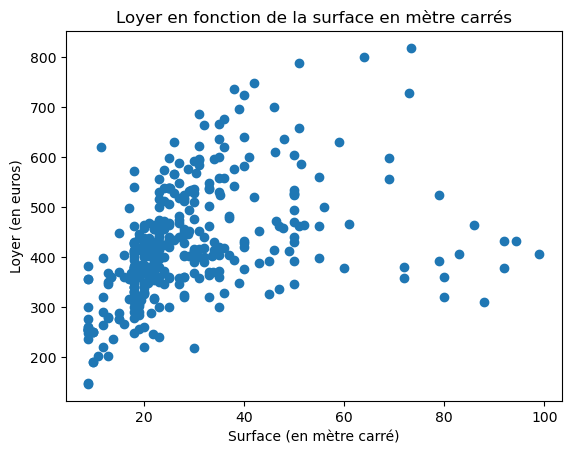

In [108]:
"""
on regarde la répartition des loyers en fonction de la surface.
"""
plt.scatter(df2['Max Surface'], df2['Max Loyer'])
plt.title('Loyer en fonction de la surface en mètre carrés')
plt.xlabel('Surface (en mètre carré)')
plt.ylabel('Loyer (en euros)')
plt.show()

In [110]:
"""
On détaille les étapes pour définir la régression. 
Pour les régressions suivantes, on fera directement appel à la régression get_OLS_reg définie dans le fichier functions_for_modelling.py .
"""

y = df2['Max Loyer'] #on définit la variable expliquée

x = df2['Max Surface'] #on définit la variable explicative

x = sm.add_constant(x) #on ajoute une constante au vecteur de prédiction

model = sm.OLS(y, x).fit() #on définit le modèle de régression linéaire

print(model.summary()) #on affiche le résumé de la régression

                            OLS Regression Results                            
Dep. Variable:              Max Loyer   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     81.68
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           8.99e-18
Time:                        13:08:37   Log-Likelihood:                -2256.1
No. Observations:                 373   AIC:                             4516.
Df Residuals:                     371   BIC:                             4524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         334.1737     10.927     30.583      

In [111]:
#le R² de 0.18 est plutôt faible, la variable explicative (ici la surface moyenne) n'est pas très utile pour prédire le résultat. 
#La p-value indique que l'on rejette H0 à 1% et que le coefficient égal à 3.43 est significatif.
#

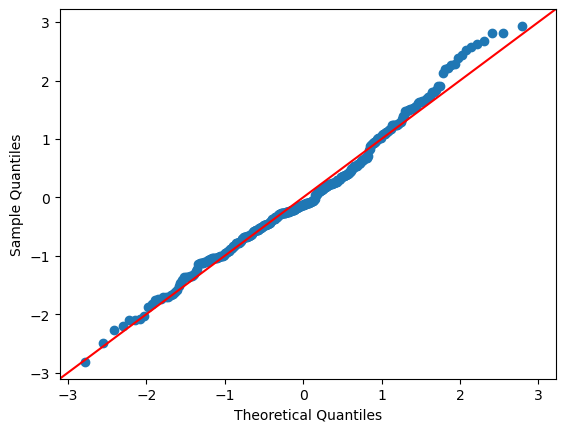

In [112]:
res = model.resid #on définit la variable res pour désigner les résidus

"""
On créé un Q-Q plot (Quantile-Quantile plot): ce type de graphe permet de voir si une variable a une distribution normale.
On compare la distribution des quantiles de l'échantillon à la distribution théorique (une droite à 45°) des quantiles d'une variable normalement distribuée.
Si les quantiles de l'échantillon des résidus (en bleu) sont sur la droite de 45° alors ils sont normalement distribués.

On affichera ensuite directement ce graphe lorsque l'on effectuera une régression avec la fonction get_OLS_reg du fichier functions_for_modelling.py.
"""
fig = sm.qqplot(res, fit=True, line="45")
plt.show() 


In [113]:
""" 
On effectuer les tests de Breusch-Pagan et de White afin d'avoir une indication plus précise sur l'homoscédasticité ou non des résidus.
"""

bp_test=sm.stats.diagnostic.het_breuschpagan(res,x)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']

print('breusch_pagan_results=',dict(zip(labels, bp_test)))

breusch_pagan_results= {'LM Statistic': 53.89762985206857, 'LM-Test p-value': 2.112123373365553e-13, 'F-Statistic': 62.66334112732401, 'F-Test p-value': 2.8669602765552434e-14}


In [51]:
#La p-value est inférieure à 0.05 donc d'après ce test, le modèle semble hétéroscedastique.
#Le seul inconvénient du test de Breusch-Pagan est qu'il peut donner une faible p-value même quand le modèle n'est pas hétéroscedastique.
#En effet, si le modèle est imparfait, généralement en raison d'un biais de variable omise, le test peut alors indiquer une p-value faible.

In [53]:
get_bp_test_OLS(df2['Max Surface'],df2['Max Loyer']) 
#on effectue le test de Breusch-Pagan pour avoir une idée de l'homoscedasticité ou non des résidus. 
#on effectue ce test désormais directement avec la fonction get_bp_test.
#la p-value est inférieure à 0,05 signe d'hétéroscedatisité des résidus et/ou d'un biais de variable omise.

('breusch_pagan_results=',
 {'LM Statistic': 53.89762985206857,
  'LM-Test p-value': 2.112123373365553e-13,
  'F-Statistic': 62.66334112732401,
  'F-Test p-value': 2.8669602765552434e-14})

In [56]:
"""
On effectue une régression prenant en compte une possible hétéroscedasticité des résidus avec le module RLM (Robust Linear Method) de statsmodel. 
"""
x = sm.add_constant(df2['Max Surface']) #on ajoute l'intercept à la variable explicative, qui n'est pas inclus par défaut avec le module RLM. 
rlm_model = sm.RLM(df2['Max Loyer'], x).fit()
print('coefficients = ',rlm_model.params)
print('standard errors=',rlm_model.bse)
print(rlm_model.summary())

coefficients =  const          320.205642
Max Surface      3.375358
dtype: float64
standard errors= const          10.522973
Max Surface     0.320063
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:              Max Loyer   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        10:57:49                                         
No. Iterations:                    15                                         
                  coef    std err          z 

In [57]:
# On remarque que l'écart type (std err) du coefficient associé à Max Surface a diminuée et le coefficient reste significatif puisqu'on rejette H0 à 1% (pvalue < 0.01).
#On remarque également que l'intervalle de confiance est plus restreint.
#La régression est donc plus précise avec le module RLM.
#On privilegiera désormais le module RLM pour effectuer des régressions, puisque celui-ci prend en compte une possible hétéroscedasticité des résidus.

In [ ]:
REGRESSION SIMPLE PRIX AU M² MAX SUR LOYER PRIV2
LA MËME SUR LE NOMBRE D'ETUDIANTS
REGRESSION LONGUE AVEC LES DEUX VARIABLES

## III.3 On cherche maintenant à prédire le prix au mètre carré des résidences crous

### III.3.A Régression linéaire du prix par mètre carré des résidences Crous ('Mean Loyer'/'Mean Surface') expliqué par le prix au m² des appartements privés loués. 

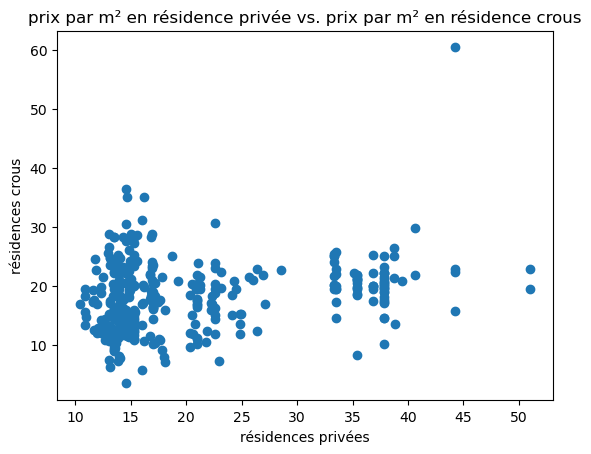

In [60]:
#on représente le prix au mètre carré des résidences crous en fonction du prix au mètre carré des résidences privées
plt.scatter(df2['upr.IPm2'], df2['Mean Loyer']/df2['Mean Surface'])
plt.title('prix par m² en résidence privée vs. prix par m² en résidence crous')
plt.xlabel('résidences privées')
plt.ylabel('résidences crous')
plt.show()

In [105]:
#on définit le modèle de régression linéaire de la même façon que précédemment, la fonction get_OLS_reg résume les commandes précédentes
get_RLM(df2['upr.IPm2'],df2['Mean Loyer']/df2['Mean Surface'])

                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  373
Model:                            RLM   Df Residuals:                      371
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        12:45:19                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.6760      0.643     22.840      0.0

In [62]:
#le R² est très proche de zéro: comme on pouvait s'y attendre, le prix par mètre carré des loyers privés est peu pertinant pour expliquer le prix par mètre carré des loyers des résidences du crous

### III.3.B Régression linéaire du prix au mètre carré des résidences crous sur le nombre d'étudiants total

In [64]:
df2['Nbstudents_total'].describe()

count       373.000000
mean      92742.745308
std      111873.041768
min           0.000000
25%       10029.000000
50%       36442.000000
75%       74156.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

In [65]:
""" 
On crée un nouveau dataframe df_students avec seulement les résidences avec plus de 1000 étudiants. 
On retire ainsi en grande majorité les valeurs manquantes et les valeurs non significatives qui viendraient fausser la régression.
"""
i = df2[df2['Nbstudents_total']<=1000].index.values
df_students = df2.drop(i,axis=0)
df_students['Nbstudents_total'].describe()

count       321.000000
mean     107766.492212
std      113689.237656
min        1682.000000
25%       26664.000000
50%       44394.000000
75%      269138.000000
max      323129.000000
Name: Nbstudents_total, dtype: float64

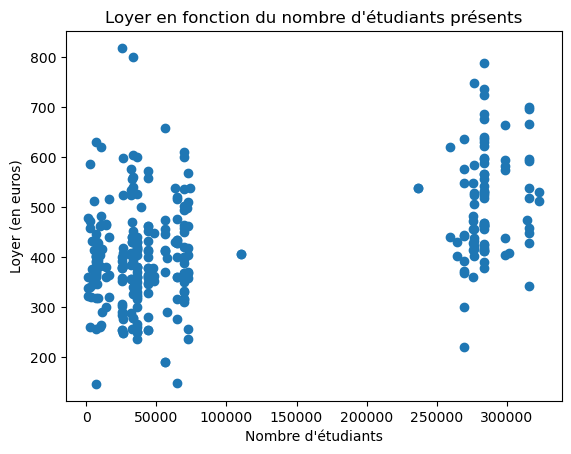

In [66]:
#on regarde le nombre d'étudiants payant un certain loyer
plt.scatter(df_students['Nbstudents_total'], df_students['Max Loyer']) 
plt.title("Loyer en fonction du nombre d'étudiants présents")
plt.xlabel("Nombre d'étudiants")
plt.ylabel('Loyer (en euros)')
plt.show()

In [106]:
x= df_students['Nbstudents_total']
y = df_students['Max Loyer']
get_RLM(x,y)

                    Robust linear Model Regression Results                    
Dep. Variable:              Max Loyer   No. Observations:                  321
Model:                            RLM   Df Residuals:                      319
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        12:48:40                                         
No. Iterations:                    17                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              372.8015      7.534  

In [68]:
"""
On effectue une régression plus longue pour essayer d'identifier la présence d'un biais de sélection.
"""
x = sm.add_constant(df_students[['Max Surface','Nbstudents_total']]) #on ajoute l'intercept à la variable explicative. 
rlm_model = sm.RLM(df_students['Max Loyer'], x).fit()

print(rlm_model.summary())

                    Robust linear Model Regression Results                    
Dep. Variable:              Max Loyer   No. Observations:                  321
Model:                            RLM   Df Residuals:                      318
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        10:57:53                                         
No. Iterations:                    21                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              285.2773     10.727  

## III.4 L'élasticité prix du mètre carré dans les résidences crous

##### On travaille désormais avec le dataframe df_students et on s'intéresse au prix du mètre carré des résidences crous.

### III.4.A Régression linéaire 'courte' du log du prix par mètre carré dans les résidences crous sur le log du nombre d'étudiants 

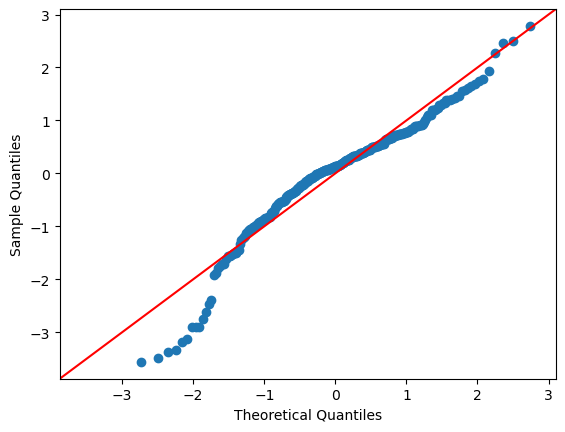

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        prix_par_m2_max   R-squared:                       0.025
 Model:                            OLS   Adj. R-squared:                  0.022
 Method:                 Least Squares   F-statistic:                     8.151
 Date:                Mon, 19 Dec 2022   Prob (F-statistic):            0.00459
 Time:                        10:57:53   Log-Likelihood:                -160.72
 No. Observations:                 321   AIC:                             325.4
 Df Residuals:                     319   BIC:                             333.0
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [70]:
x= np.log(df_students['Nbstudents_total'])
y= np.log(df_students['prix_par_m2_max'])
get_OLS_reg(x,y)

In [71]:
"""
On remarque que certains points dévient de la droite à 45 degrés sur le graphique. On effectue une régression robuste.
"""
resrlm = sm.RLM(y, x).fit()
print('coefficient = ',resrlm.params)
print('standard error=',resrlm.bse)
print(resrlm.summary())

coefficient =  Nbstudents_total    0.25424
dtype: float64
standard error= Nbstudents_total    0.002332
dtype: float64
                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  321
Model:                            RLM   Df Residuals:                      320
Method:                          IRLS   Df Model:                            0
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        10:57:53                                         
No. Iterations:                    14                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
-------

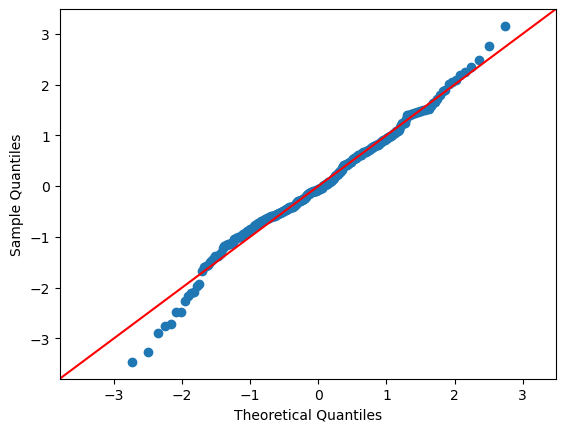

In [72]:
 res = resrlm.resid
fig = sm.qqplot(res, fit=True, line="45") 

In [73]:
""" 
On effectuer le test de Breusch-Pagan sur la régression RLM.
"""

#bp_test=sm.stats.diagnostic.het_breuschpagan(res,x)
test_bp_results= sms.het_breuschpagan(res, resrlm.model.exog)
labels = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
 
print('breusch_pagan_results=',dict(zip(labels, test_bp_results)))

breusch_pagan_results= {'Lagrange multiplier statistic': 75.88512230342211, 'p-value': nan, 'f-value': 99.06880955286094, 'f p-value': 1.6454675583745354e-20}


### III.3.B Régression longue du prix par mètre carré des résidences Crous ('Max Loyer'/'Max Surface') expliqué par le nombre d'étudiants total et le prix au mètre carré des résidences privées

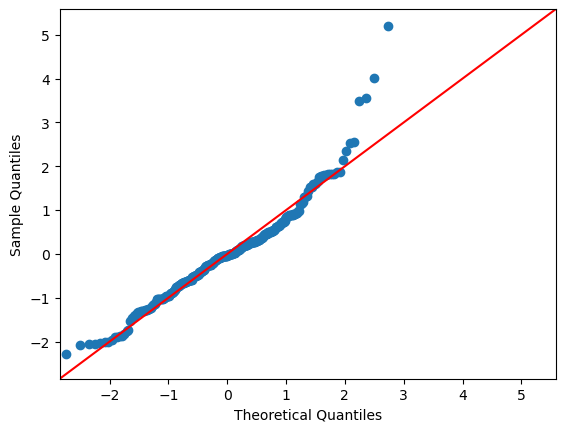

(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        prix_par_m2_max   R-squared:                       0.028
 Model:                            OLS   Adj. R-squared:                  0.022
 Method:                 Least Squares   F-statistic:                     4.518
 Date:                Mon, 19 Dec 2022   Prob (F-statistic):             0.0116
 Time:                        12:24:26   Log-Likelihood:                -1047.0
 No. Observations:                 321   AIC:                             2100.
 Df Residuals:                     318   BIC:                             2111.
 Df Model:                           2                                         
 Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------

In [100]:
get_OLS_reg(df_students[['Nbstudents_total','upr.IPm2']],df_students['prix_par_m2_max'])

In [101]:
get_bp_test_OLS(df_students[['Nbstudents_total','upr.IPm2']],df_students['prix_par_m2_max'])

('breusch_pagan_results=',
 {'LM Statistic': 6.79016693555725,
  'LM-Test p-value': 0.033537754733431124,
  'F-Statistic': 3.43603677906596,
  'F-Test p-value': 0.03339208924081505})

In [76]:
#on obtient presque le même graphique que pour la régression simple des prix au mètre carré des résidences crous sur les prix au mètre carré des résidences privées.
#le coefficient associé au nombre d'étudiants total est extrêmement faible.

In [102]:
get_RLM(df_students[['Nbstudents_total','upr.IPm2']],df_students['prix_par_m2_max'])

                    Robust linear Model Regression Results                    
Dep. Variable:        prix_par_m2_max   No. Observations:                  321
Model:                            RLM   Df Residuals:                      318
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Mon, 19 Dec 2022                                         
Time:                        12:24:47                                         
No. Iterations:                    16                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               14.5436      1.112  